<a href="https://colab.research.google.com/github/s3965610/COSC2671-A2/blob/asif_community_detection/community_detection_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Community detection based on language

We implement the louvain algorithm on a graph where each user is a node and connected with an edge if there is 1 or more programming languages common in them. We also attempt to run the baseline recommender system in each of the communities formed. 

We have implemented an heuristic appraoch to the Lovain algorithm implemented in this link
code reference: https://perso.crans.org/aynaud/communities/

Moreover, most of the visualisation has been also borrowed from code reference: https://www.kaggle.com/code/kevinvdsk/community-detection

In [ ]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import random
from pandas import json_normalize
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import networkx as nx
import community
from community import community_louvain
import random
import csv
import itertools
!pip install surprise
from surprise import accuracy
from collections import defaultdict
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, KNNBasic, KNNBaseline, SVD, AlgoBase
from surprise.model_selection import cross_validate, train_test_split, LeaveOneOut

## Recommender system Classes

In [ ]:
%load_ext autoreload
%autoreload 1
%aimport rs_evaluator

## Data Preparation

In [3]:
# directory must be changed to local from google drive
with open("/data/user_info.json", "r") as read_file:
    user_infos = json.load(read_file)
with open("/data/user-items-ratings-improved.csv", "r") as read_file:
    user_item_data = pd.read_csv(read_file)

In [4]:
user_item_data.head(5)

,user_id,repo_id,rating
0,0x00evil,SwiftGGTeam/the-swift-programming-language-in-...,2
1,0x00evil,atom/atom,3
2,0x00evil,capistrano/capistrano,3
3,0x00evil,git/git,3
4,0x00evil,golang/go,3


In [5]:
# generate a dictionary where each user is key with a list of languages they 
# used as value
language_dict = {}
for i in user_infos:
    language_dict[i] = []
    nodes = []
    if( user_infos[i]['data']!= None):
        nodes = user_infos[i]['data']['user']['repositories']['nodes']
        
    for n in nodes:
        if(n['primaryLanguage'] != None):
            
            language_dict[i].append(n['primaryLanguage']['name'])
        
 
        
languages = []
for key, val in language_dict.items():
    language_dict[key] = set(val)
    languages.extend(val)
languages = set(languages)


## Create graph
Graph is created by building an edge if two users have common languages used in their repositories. The wieght of the edge is the number of common programming languages used

In [6]:
G = nx.Graph()
users = list(language_dict.keys())

count = 0
for i in range(len(users) - 1):
    user = users[i]
    for j in range(i + 1, len(users)):
        user2 = users[j]
        common_languages = language_dict[user].intersection(language_dict[user2])
        # check if common exists
        if(len(common_languages) > 0):
            count += 1
            G.add_edge(user,  user2, weight = len(common_languages))


In [7]:
print("Graph size: ", count)

Graph size:  1221167


In [8]:
partition = community_louvain.best_partition(G)
print('Modularity of best partition: ', community_louvain.modularity(partition, G))

Modularity of best partition:  0.12289526498181881


## Visualise the graph

In [9]:
comms_dict = {}
# generate comms distionary
for lComms in set(partition.values()) :
    comms_dict[lComms] = [nodes for nodes in partition.keys() if partition[nodes] == lComms]

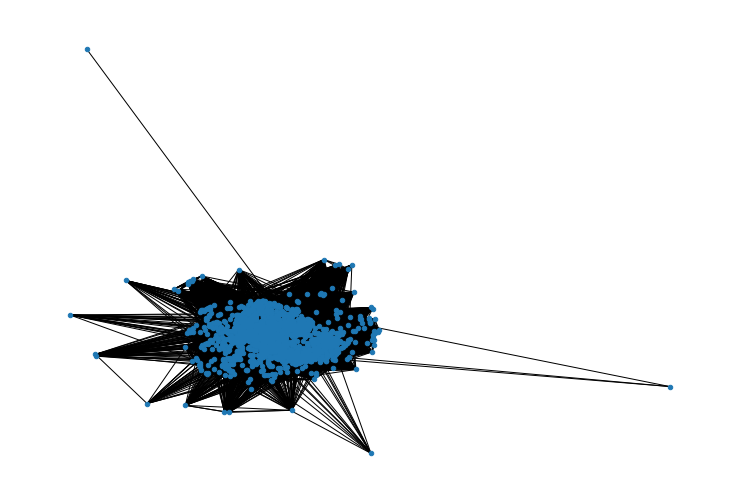

In [10]:
# code reference: https://www.kaggle.com/code/kevinvdsk/community-detection

# Draw graph
plt.figure(figsize=(13, 9))
n_partition = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
for val in comms_dict.values() :
    nx.draw_networkx_nodes(G, pos, val, node_size = 20)
nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.show()



## Form Communities

In [11]:
# heuristic approach to Louvain algorithm as 
# described here https://perso.crans.org/aynaud/communities/
centers = {}
communities = {}
G_copy = G.copy()
min_nb = 30
community_list = []
for lComms , nodes in comms_dict.items() :
    
    if len(nodes) < min_nb:
        G_copy.remove_nodes_from(nodes)
    else:
        
        subgraph = G_copy.subgraph(nodes)
        d = nx.degree_centrality(subgraph)
        comm_name = max(d, key=d.get)
        centers[comm_name] = lComms
        communities[lComms] = comm_name
        community_list.append(nodes)
        print('Community name ', comm_name, '(clusId ', lComms, ') - ', len(nodes), ' users:')
        print(nodes, '\n')

Community name  mataralhawiti (clusId  0 ) -  749  users:
['jheins3', 'jiguorui', 'jimmystelzer', 'jmsykes15', 'jodfie', 'jodyford', 'johan--', 'jokemilk', 'jorfde', 'jorgevila', 'judell', 'juicelite', 'justBanks', 'justinjohn0306', 'jwballan', 'k0544530931', 'kaloprominat', 'kaloyan', 'kamino', 'kankungyip', 'kapilt', 'karimmd', 'karthiksripal', 'kaschubert', 'kayiwa', 'kcmvp', 'kenhehuang', 'keon', 'kerbrose', 'khalidmarescalchi', 'kilbee', 'killua001', 'kjaft', 'knittledan', 'koenvo', 'kondalrao', 'kounch', 'kozo2', 'kreely', 'krishnakumar4a4', 'kroggen', 'kvmc', 'kycent', 'l10xbin', 'lafengnan', 'laonger', 'lastnamelefty', 'laurencecao', 'leeyisoft', 'lendo', 'leonlai', 'levocode', 'lgnq', 'lin7sh', 'linhx13', 'lipchanskiy', 'lisai9093', 'littlebearz', 'litvinovmitch11', 'liudhzhyym', 'liugangnhm', 'liuzl', 'liverbool', 'livestalker', 'ljyong2010', 'lmommaerts', 'loftwah', 'loki-sama', 'lorenzofilizola', 'loyning', 'lukepistrol', 'lulucca12', 'lxb1628', 'ly0', 'machorro', 'maddanio

## Visualise communities

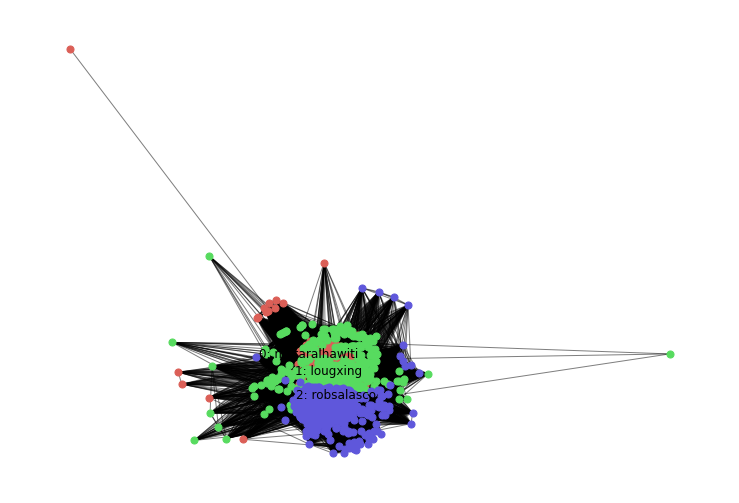

In [12]:

import seaborn as sns
# Display graph
# code reference: https://www.kaggle.com/code/kevinvdsk/community-detection
# Display graph
plt.figure(figsize=(13, 9))
node_size = 50
count = 0
pos = nx.spring_layout(G_copy)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_copy, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_copy, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_copy, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(G_copy, pos, labels)
plt.axis('off')
plt.show()



## Community induced graph

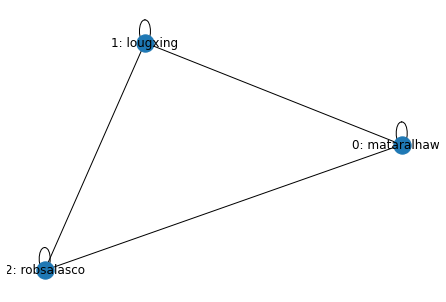

In [36]:



# Display induced graph
nodes_main_com = {k: v for k, v in partition.items() if v in communities}
ind = community_louvain.induced_graph(nodes_main_com, G_copy)

pos_ind = nx.spring_layout(ind)
labels = {k: str(k) + ': ' + v for k,v in communities.items()}
nx.draw(ind, pos_ind,  labels=labels)
plt.show()



## Language in each community

In [63]:
sns.set_theme(style="whitegrid")
def plot_com_language(com_list):
    language0 = []
    for user in com_list:
        language0.extend(list(language_dict[user]))
    lang_df = pd.DataFrame (language0, columns = ['language'])
    sns.countplot(x = 'language', data = lang_df, order=lang_df.language.value_counts().iloc[:5].index)

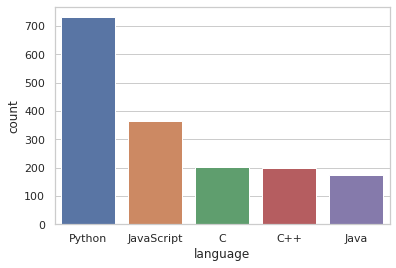

In [64]:
plot_com_language(community_list[0])



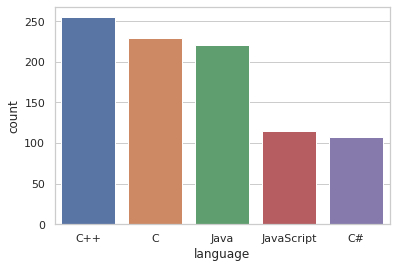

In [65]:
plot_com_language(community_list[1])

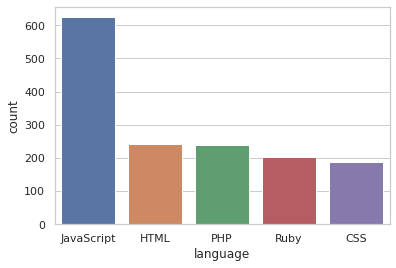

In [66]:
plot_com_language(community_list[2])

## Recommender system evaluation

###Genrate  dataframes for each cluster

In [ ]:
c0_df = user_item_data[user_item_data['user_id'].isin(community_list[0])]
c1_df = user_item_data[user_item_data['user_id'].isin(community_list[1])]
c2_df = user_item_data[user_item_data['user_id'].isin(community_list[2])]


In [23]:
def evaluate_rec_sys(df):
    """
    function runs the recommendation system on each
    of the dataframes of the clusters
    """


    repo_rankings = df.groupby(['repo_id']).rating.sum().sort_values(ascending=False)
    


    temp = df.copy()
    # temp['rating'] = temp['rating']+1

    temp['user_id'] = temp['user_id'].astype('category')
    temp['repo_id'] = temp['repo_id'].astype('category')

    # ulabels, ulevels = pd.factorize(temp['user_id'])
    # rlabels, rlevels = pd.factorize(temp['repo_id'])
    temp = pd.DataFrame({
        'user_name': temp['user_id'],
        'user_id': temp['user_id'].cat.codes,
        'repo_name': temp['repo_id'],
        'repo_id': temp['repo_id'].cat.codes,
        'rating': temp['rating']
    })

    reader = Reader(rating_scale=(1, 3))
    data = Dataset.load_from_df(temp[['user_id', 'repo_id', 'rating']], reader)

    # setup an evaluator
    evaluator = Evaluator(data, repo_rankings)

    evaluator.algorithms = []

    # USER-BASED KNN
    user_knn = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})

    # SVD
    svd = SVD()

   
    evaluator.add_algorithm('User KNN', user_knn)
    evaluator.add_algorithm('SVD', svd)


    # Run the evals
    evaluator.evaluate()




## Results of recommender systems

In [68]:
evaluate_rec_sys(c0_df)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating User KNN...
Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating top-10 with LOOCV..
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating rank metrics...
Computing recs with complete dataset...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done.
Evaluating SVD...
Evaluating accuracy...
Evaluating top-10 with LOOCV..
Evaluating rank metrics...
Computing recs with complete dataset...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done.

Algorithm  RMSE       MAE        HR         CHR        ARHR       Coverage   Diversity  Novelty   
User KNN   0.9418     0.7757     0.0298     0.0298     0.0089     1.0000     0.8222     23.2461   
SVD        0.8349  

In [69]:
evaluate_rec_sys(c2_df)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating User KNN...
Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating top-10 with LOOCV..
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating rank metrics...
Computing recs with complete dataset...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done.
Evaluating SVD...
Evaluating accuracy...
Evaluating top-10 with LOOCV..
Evaluating rank metrics...
Computing recs with complete dataset...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done.

Algorithm  RMSE       MAE        HR         CHR        ARHR       Coverage   Diversity  Novelty   
User KNN   0.8900     0.7370     0.0198     0.0198     0.0063     1.0000     0.7043     28.7167   
SVD        0.8345  